# Final Results Analysis: A Comparative Study of CQL Agents

**Project:** Long-Tail Offline RL

**Objective:** To load the aggregated evaluation results for all trained agents,
visualize their performance across key metrics, and draw conclusions about the
effectiveness of different data curation and weighting strategies.

In [1]:
# ## 1. Setup and Configuration

import os
import sys
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config
from src.data_processing.validate_parser_output import visualize_scenario

# Load project config and set plot style
config = load_config(config_path='../configs/main_config.yaml')

sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.1)

Configuration loaded successfully.


In [2]:
# ## 2. Load and Aggregate All Experimental Results
# 
# This cell finds all available `aggregated_metrics_summary.json` files based
# on a predefined list of expected runs. It will gracefully handle missing files,
# allowing the analysis to proceed even with an incomplete set of experiments.
pd.set_option('display.precision', 2)
# +
outputs_dir = '../outputs'

# --- Define a mapping for all expected runs and their clean plot names ---
# This dictionary now drives the entire data loading process.
run_name_to_agent = {
    'CQL_B_BCLoss_final_quantitative_eval': 'CQL+BC (Baseline)',
    'CQL_H_final_quantitative_eval': 'CQL-H (Heuristic)',
    'CQL_HS_final_quantitative_eval': 'CQL-HS (Heuristic Scenario)',
    'CQL_E_final_quantitative_eval': 'CQL-E (Ensemble)',
    'CQL_ES_final_quantitative_eval': 'CQL-ES (Ensemble Scenario)',
    'CQL_AR_final_quantitative_eval': 'CQL-AR (Action Rarity)',
    'CQL_ARS_final_quantitative_eval': 'CQL-ARS (Action Rarity Scenario)',
}

all_results = []
print("--- Searching for evaluation results ---")

# --- Iterate through the expected runs and load any that exist ---
for run_name, agent_name in run_name_to_agent.items():
    # Construct the expected path for the summary file
    summary_path = os.path.join(outputs_dir, run_name, 'aggregated_metrics_summary.json')
    
    if os.path.exists(summary_path):
        print(f"✅ Found results for: {agent_name}")
        with open(summary_path, 'r') as f:
            data = json.load(f)
        
        summary = data['metrics_summary']
        
        # Flatten the nested dictionary into a single record
        record = {
            'agent_name': agent_name,
            'collision_rate': summary['safety']['collision_rate_percent'],
            'offroad_rate': summary['safety']['offroad_rate_percent'],
            'success_rate': summary['goal_achievement']['success_rate_percent'],
            'progression': summary['goal_achievement']['average_progression_on_success_meters'],
            'dist_to_goal': summary['goal_achievement']['average_final_distance_to_goal_meters'],
            'route_adherence': summary['goal_achievement']['average_route_adherence_error_meters'],
            'max_jerk': summary['comfort']['average_max_jerk_on_success'],
            'max_lat_accel': summary['comfort']['average_max_lateral_acceleration_on_success'],
            'red_light_violations': summary['rule_compliance']['red_light_violation_rate_percent'],
        }
        all_results.append(record)
    else:
        print(f"🟡 Skipping (file not found): {agent_name}")

# --- Final Check ---
if not all_results:
    raise FileNotFoundError(f"No aggregated summary files could be found in any expected location within '{outputs_dir}'. "
                            "Please ensure at least one evaluation run is complete.")

# Create the final DataFrame
results_df = pd.DataFrame(all_results)
# Sort by a key metric for a sensible default plot order
results_df = results_df.sort_values(by='collision_rate').reset_index(drop=True)

print("\n\n--- Aggregated Performance Metrics (Found Runs) ---")
display(results_df)

--- Searching for evaluation results ---
✅ Found results for: CQL+BC (Baseline)
✅ Found results for: CQL-H (Heuristic)
✅ Found results for: CQL-HS (Heuristic Scenario)
🟡 Skipping (file not found): CQL-E (Ensemble)
✅ Found results for: CQL-ES (Ensemble Scenario)
🟡 Skipping (file not found): CQL-AR (Action Rarity)
✅ Found results for: CQL-ARS (Action Rarity Scenario)


--- Aggregated Performance Metrics (Found Runs) ---


,agent_name,collision_rate,offroad_rate,success_rate,progression,dist_to_goal,route_adherence,max_jerk,max_lat_accel,red_light_violations
0,CQL-H (Heuristic),8.0,20.5,74.5,27.50,1.64,0.30,7.60,0.89,3.5
1,CQL-ES (Ensemble Scenario),8.5,22.0,75.0,28.94,1.37,0.25,7.32,0.88,3.0
2,CQL-ARS (Action Rarity Scenario),9.0,17.0,78.5,32.71,1.31,0.19,7.53,0.89,5.0
3,CQL+BC (Baseline),11.0,29.0,69.5,27.97,1.58,0.22,6.55,0.75,5.5
4,CQL-HS (Heuristic Scenario),11.5,25.5,72.0,40.69,1.72,0.18,7.85,1.02,5.0


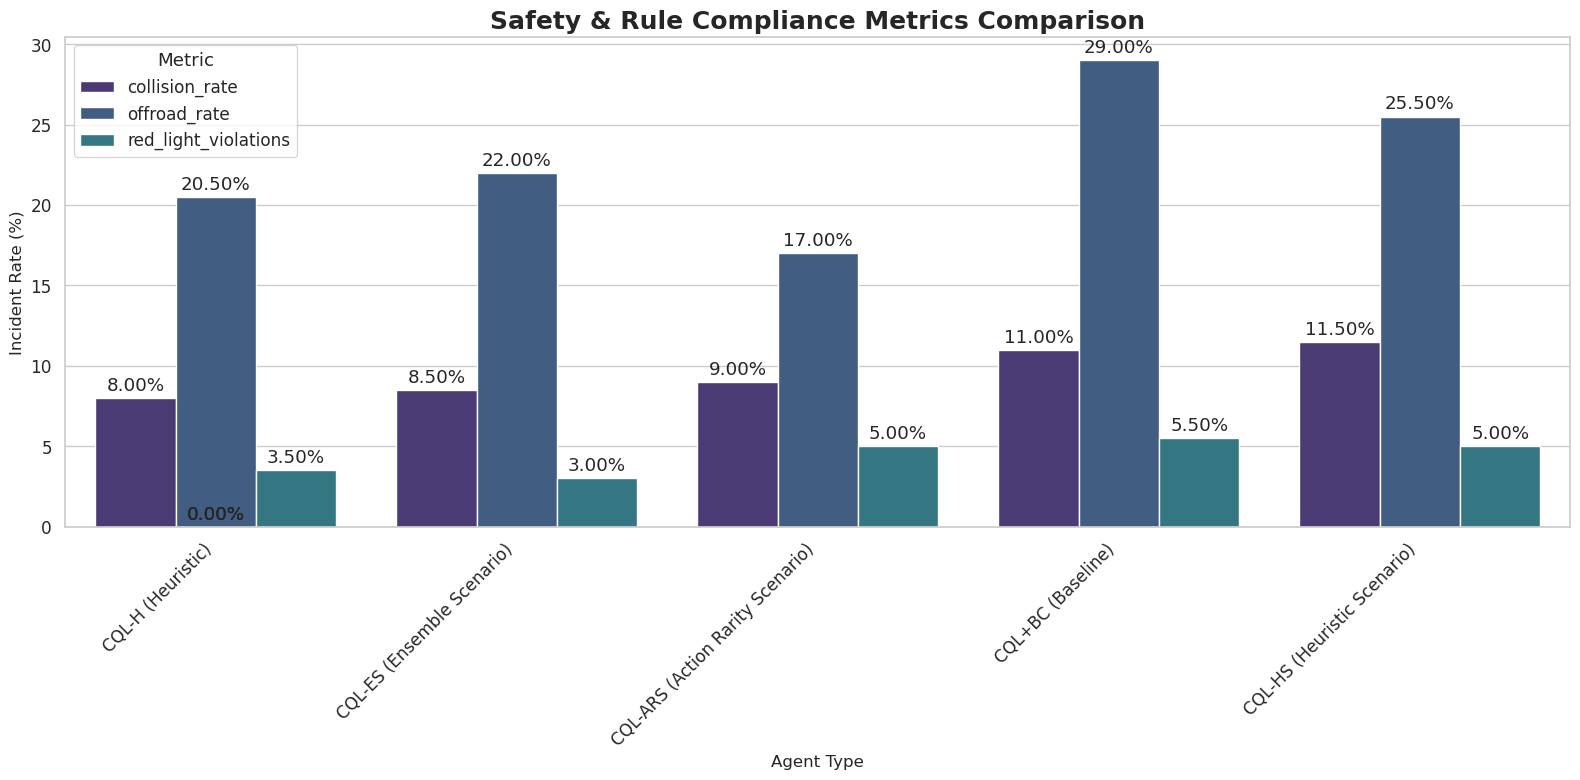

In [3]:
# ## 3. Visualize Safety Metrics
# 
# Safety is the most important pillar. Let's compare collision, off-road, and red light violation rates. Lower is better.

# +
# Prepare data for plotting
safety_metrics = pd.melt(
    results_df, 
    id_vars=['agent_name'], 
    value_vars=['collision_rate', 'offroad_rate', 'red_light_violations'],
    var_name='Metric', 
    value_name='Rate (%)'
)

plt.figure(figsize=(16, 8))
ax = sns.barplot(data=safety_metrics, x='agent_name', y='Rate (%)', hue='Metric')
ax.set_title('Safety & Rule Compliance Metrics Comparison', fontsize=18, weight='bold')
ax.set_xlabel('Agent Type', fontsize=12)
ax.set_ylabel('Incident Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1318/1848848277.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1318/1848848277.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


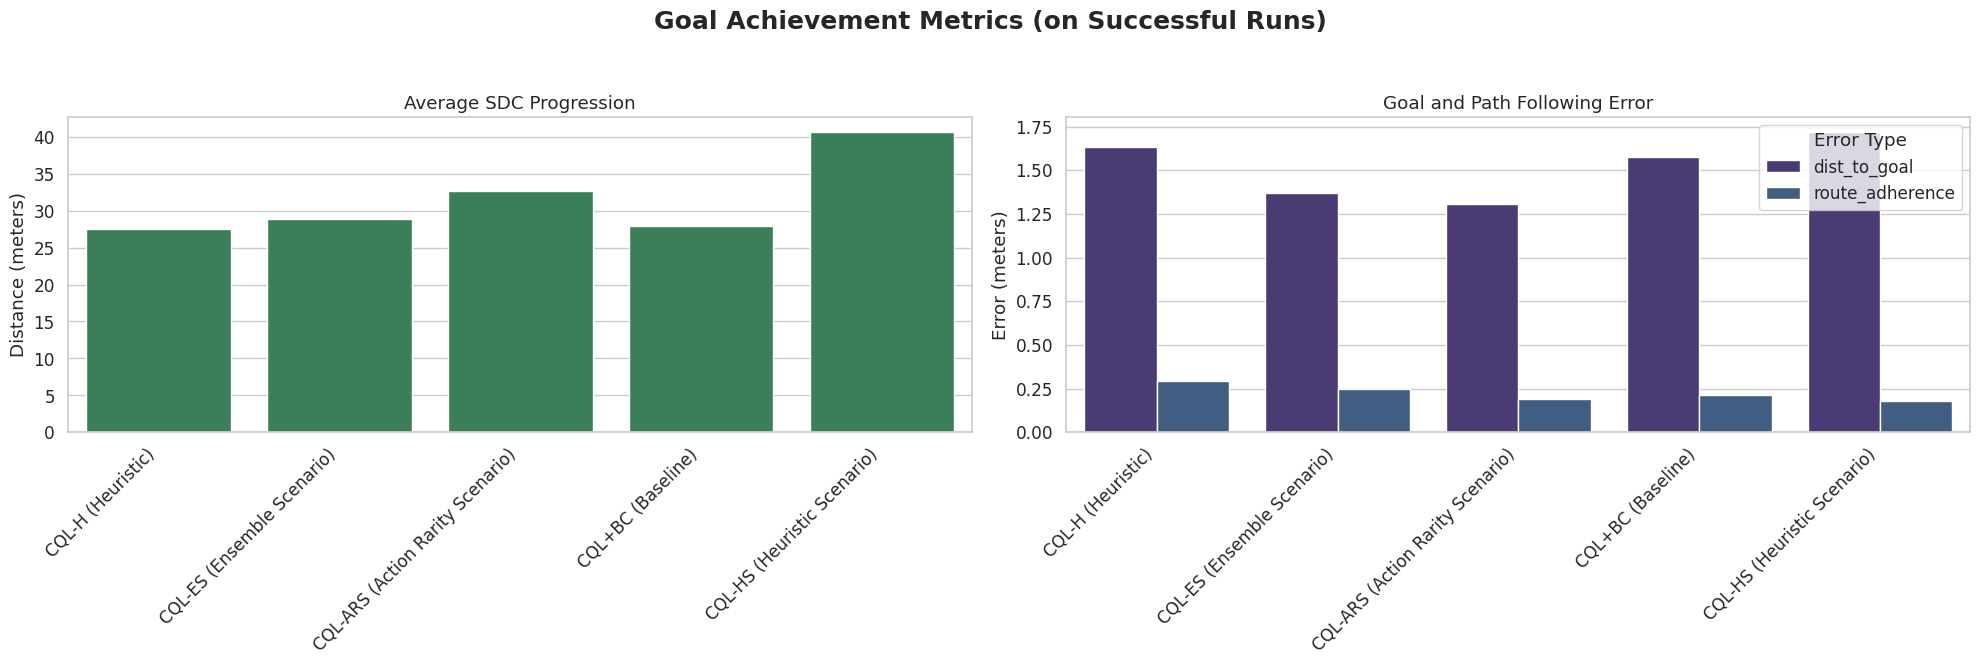

In [4]:
# ## 4. Visualize Goal Achievement Metrics
# 
# Here we evaluate how effectively the successful agents completed their mission. For progression, higher is better. For distance and adherence, lower is better.

# +
fig, axes = plt.subplots(1, 2, figsize=(20, 7)) # Don't sharex, it can cause issues
fig.suptitle('Goal Achievement Metrics (on Successful Runs)', fontsize=18, weight='bold')

# --- Plot 1: Progression ---
sns.barplot(data=results_df, x='agent_name', y='progression', ax=axes[0], color='seagreen')
axes[0].set_title('Average SDC Progression')
axes[0].set_ylabel('Distance (meters)')
axes[0].set_xlabel('')
# --- CORRECTED ROTATION ---
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# --- Plot 2: Goal and Path Error ---
goal_metrics = pd.melt(
    results_df, 
    id_vars=['agent_name'], 
    value_vars=['dist_to_goal', 'route_adherence'],
    var_name='Error Type', 
    value_name='Distance (m)'
)
sns.barplot(data=goal_metrics, x='agent_name', y='Distance (m)', hue='Error Type', ax=axes[1])
axes[1].set_title('Goal and Path Following Error')
axes[1].set_ylabel('Error (meters)')
axes[1].set_xlabel('')
# --- CORRECTED ROTATION ---
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

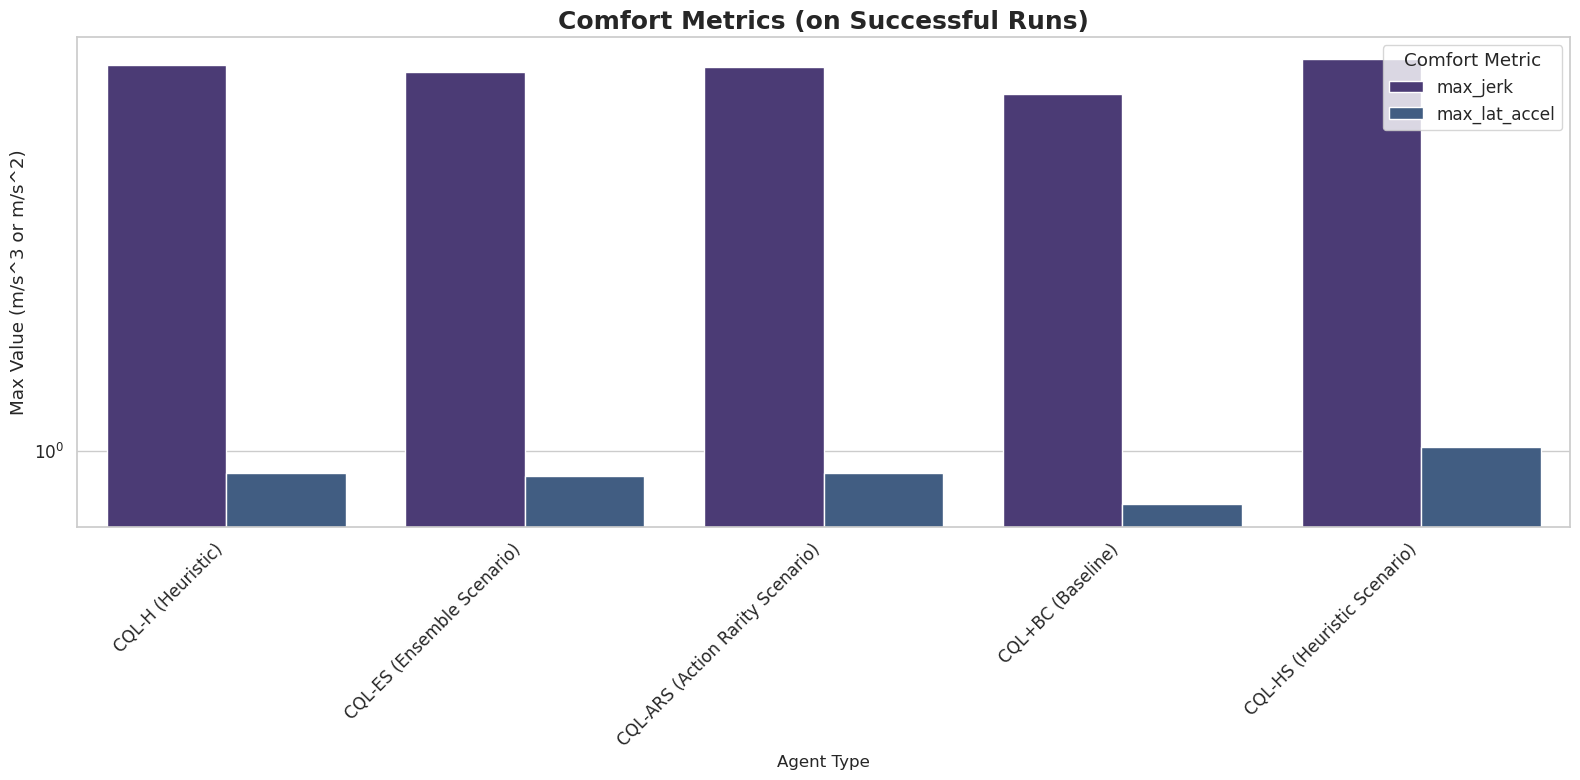

In [5]:
# ## 5. Visualize Comfort Metrics
# 
# These metrics evaluate the ride quality. Lower is better for both.

comfort_metrics = pd.melt(
    results_df, 
    id_vars=['agent_name'], 
    value_vars=['max_jerk', 'max_lat_accel'],
    var_name='Comfort Metric', 
    value_name='Value'
)

plt.figure(figsize=(16, 8))
ax = sns.barplot(data=comfort_metrics, x='agent_name', y='Value', hue='Comfort Metric')
ax.set_title('Comfort Metrics (on Successful Runs)', fontsize=18, weight='bold')
ax.set_xlabel('Agent Type', fontsize=12)
ax.set_ylabel('Max Value (m/s^3 or m/s^2)')
ax.set_yscale('log')

# --- CORRECTED ROTATION (using the plt interface) ---
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()